In [1]:
#!/usr/bin/env python
# coding: utf-8
get_ipython().run_line_magic('matplotlib', 'inline')
import pandas as pd
import time
import numpy as np
from datetime import datetime
from sklearn.externals import joblib 
import os
from konlpy.tag import Mecab
import lightgbm as lgb
print(lgb.__version__)

from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib 
from sklearn.model_selection import StratifiedKFold

import gc

from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings(action='ignore')


import torch
print(torch.__version__)
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchsummary import summary

from tools import eval_summary

print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')
device

/home/aiden/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


2.3.2
1.3.1
GeForce RTX 2070 SUPER
True


device(type='cuda', index=0)

In [2]:
print(os.getcwd())

base_path = '.'

df_train = pd.read_csv(os.path.join(base_path , 'input/train.csv'), index_col=0)
df_test = pd.read_csv(os.path.join(base_path , 'input/public_test.csv'), index_col=0)
df_test['smishing'] = -1

df_fea = pd.concat([df_train, df_test])
df_fea.shape

/home/aiden/src/dacon_14


(297571, 3)

In [3]:
train_size = len(df_train)
print(train_size)

cat_cols = []
# fea_cols = tfidf_cols + cat_cols + cnt_cols
# fea_cols = cnt_cols + cat_cols
# fea_cols = tfidf_cols + cat_cols
# len(fea_cols)

295945


#### Load Data

In [4]:
# merged_ts = '20191231T113708_5499'
# merged_ts = '20191231T162533_2022'
# merged_ts = '20191231T165424_6099'
# merged_ts = '20191231T111228_8180'
# merged_ts = '20200101T184353_5853'

merged_ts = '20200102T005929_6546_128_49980'

train_path = 'data/df_merged_{}_train.pkl'.format(merged_ts)
test_path = 'data/df_merged_{}_test.pkl'.format(merged_ts)
dict_path = 'data/df_merged_{}_fea_dict.pkl'.format(merged_ts)

df_model = joblib.load(train_path)  
df_test = joblib.load(test_path) 
fea_dict = joblib.load(dict_path)

print('model_set\n', df_model['smishing'].value_counts())

df_model.drop('morphs_128_idx', axis=1, inplace=True)
df_test.drop('morphs_128_idx', axis=1, inplace=True)


model_set
 0    277242
1     18703
Name: smishing, dtype: int64


In [5]:
fea_cols = [c for c in df_model.columns if c not in ['smishing', 'id', 'morphs_128_idx']]
len(fea_cols)

6545

#### Params

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

model_ts = datetime.now().strftime('%Y%m%dT%H%M%S')

initscore_filename = ''
params = {
    'boosting':'gbdt',
#     'boosting':'dart',
    'num_leaves': 7, 
#     'max_depth': 5,
    'objective': 'binary',
    'metric':'auc',
    'num_threads': 16,
    'learning_rate': 0.005,
#     'is_unbalance': True,
    'scale_pos_weight':200,
    'bagging_fraction':0.5,
    'bagging_freq':10,
    'feature_fraction':0.5,
    'initscore_filename':initscore_filename,
#     'lambda_l1':200,
#     'lambda_l2':2000,
    'device_type':'gpu',
}

data_params = {
    'max_bin':128,
#     'enable_bundle': False,
}
num_round = 8000

In [7]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 295945 entries, 0 to 336378
Columns: 6546 entries, smishing to tfidf_word_33_0499
dtypes: float16(6501), int16(44), int64(1)
memory usage: 3.6 GB


In [8]:
df_model = df_model.reset_index()

In [9]:
df_model

,id,smishing,EC,EF,EP,ETM,ETN,IC,JC,JKB,...,tfidf_word_33_0490,tfidf_word_33_0491,tfidf_word_33_0492,tfidf_word_33_0493,tfidf_word_33_0494,tfidf_word_33_0495,tfidf_word_33_0496,tfidf_word_33_0497,tfidf_word_33_0498,tfidf_word_33_0499
0,0,0,0,2,1,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.739746,0.00000,0.0,0.0,0.0
1,1,0,1,1,2,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0
2,2,0,2,5,4,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0
3,4,0,1,5,5,7,2,0,1,5,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0
4,5,0,2,1,1,1,2,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295940,336373,0,5,4,8,7,2,0,2,4,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0
295941,336375,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0
295942,336376,0,5,2,3,0,0,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0
295943,336377,0,3,2,1,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0


#### Train

In [10]:
pred_csv = []
fea_size = -1
try_cnt = 1

for t in tqdm_notebook(range(try_cnt), total=try_cnt, desc = 'Try'):
    fea_cols = [c for c in df_model.columns if c not in ['smishing', 'id', 'score']]
    
    if fea_size > 0:
        fea_cols = list(set(np.random.choice(fea_cols, fea_size)))
        print(t, len(fea_cols), fea_cols[:100])
    else:
        print(t, len(fea_cols))

    [df_model.drop(c, axis=1, inplace=True) for c in df_model.columns if 'smishing_' in c]
    [df_test.drop(c, axis=1, inplace=True) for c in df_test.columns if 'smishing_' in c]

#     X = df_model[fea_cols].values
#     y = df_model['smishing'].values

    n_splits = 5
    skf = StratifiedKFold(n_splits=n_splits, random_state=8405)
    cnt = 0
    
#     train_data = lgb.Dataset(X, label=y, feature_name=fea_cols, categorical_feature=cat_cols, 
#                              free_raw_data=False, params=data_params)

    # for train_index, valid_index in skf.split(X, y):
    for train_index, valid_index in tqdm_notebook(skf.split(df_model[fea_cols].values, df_model['smishing'].values), total=n_splits, desc = 'CV'):
        cnt = cnt + 1
        print('\n', t, '*' * 20, cnt, '*' * 20)
        
        train_set = lgb.Dataset(df_model.loc[train_index, fea_cols].values, 
                                 label=df_model.loc[train_index, 'smishing'].values, 
                                 feature_name=fea_cols, categorical_feature=cat_cols, 
                                 free_raw_data=True, params=data_params)
        
        valid_set = lgb.Dataset(df_model.loc[valid_index, fea_cols].values, 
                                 label=df_model.loc[valid_index, 'smishing'].values, 
                                 feature_name=fea_cols, categorical_feature=cat_cols, 
                                 free_raw_data=True, params=data_params)

#         train_set = train_data.subset(train_index, params=data_params).construct()
#         valid_set = train_data.subset(valid_index, params=data_params).construct()
        print('train_set', np.unique(train_set.get_label(), return_counts=True))
        print('valid_set', np.unique(valid_set.get_label(), return_counts=True))

        bst = lgb.train(params, train_set, num_round, categorical_feature=cat_cols,
                        early_stopping_rounds=300, 
                        valid_sets=[train_set, valid_set],
                        verbose_eval=200,
                        # init_model=init_model,
                       )

        print('Best Iteration:', bst.best_iteration)
        pred_tag = 'smishing_{}_{}__{}'.format(t, cnt, bst.best_iteration)

        renamed_cols = [fea_dict[c] if c in fea_dict.keys() else c for c in fea_cols]

        impt_dict = {k:v for k, v in zip(renamed_cols, bst.feature_importance(importance_type='split'))}
        print('split:', sorted(impt_dict.items(), key=(lambda x:x[1]), reverse=True)[:5])
        joblib.dump(impt_dict, 'model/{}_{}_split.pkl'.format(model_ts, pred_tag))

        impt_dict = {k:v for k, v in zip(renamed_cols, bst.feature_importance(importance_type='gain'))}    
        print('gain:', sorted(impt_dict.items(), key=(lambda x:x[1]), reverse=True)[:5])
        joblib.dump(impt_dict, 'model/{}_gain.pkl'.format(model_ts, pred_tag))

        df_model['score'] = bst.predict(df_model[fea_cols].values)    
        df_model[['score']].to_csv('submit/{}_{}_lgb_score.csv'.format(model_ts, pred_tag), index=True)
        
        print('model\n', eval_summary(df_model['smishing'].values, df_model['score'].values, cut_off=0.5))
        
        df_test['smishing'] = bst.predict(df_test[fea_cols].values)    
        df_test[['smishing']].to_csv('submit/{}_{}_lgb.csv'.format(model_ts, pred_tag), index=True)
        pred_csv.append('submit/{}_{}_lgb.csv'.format(model_ts, pred_tag))


0 6545



 0 ******************** 1 ********************
train_set (array([0, 1]), array([221793,  14962]))
valid_set (array([0, 1]), array([55449,  3741]))
Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.99992	valid_1's auc: 0.999747
[400]	training's auc: 0.999993	valid_1's auc: 0.999815
[600]	training's auc: 0.999997	valid_1's auc: 0.999885
[800]	training's auc: 0.999999	valid_1's auc: 0.999931
[1000]	training's auc: 0.999999	valid_1's auc: 0.999956
[1200]	training's auc: 1	valid_1's auc: 0.999968
[1400]	training's auc: 1	valid_1's auc: 0.99998
[1600]	training's auc: 1	valid_1's auc: 0.999985
[1800]	training's auc: 1	valid_1's auc: 0.99999
[2000]	training's auc: 1	valid_1's auc: 0.999991
[2200]	training's auc: 1	valid_1's auc: 0.999994
[2400]	training's auc: 1	valid_1's auc: 0.999995
[2600]	training's auc: 1	valid_1's auc: 0.999996
[2800]	training's auc: 1	valid_1's auc: 0.999997
[3000]	training's auc: 1	valid_1's auc: 0.999997
[3200]	training's auc: 1	va

[4200]	training's auc: 1	valid_1's auc: 0.999985
[4400]	training's auc: 1	valid_1's auc: 0.999986
[4600]	training's auc: 1	valid_1's auc: 0.999986
Early stopping, best iteration is:
[4460]	training's auc: 1	valid_1's auc: 0.999986
Best Iteration: 4460
split: [('tfidf_word_22_0132_xxx 은행', 879), ('tfidf_word_11_0307_광고', 457), ('tfidf_word_11_1263_올림', 451), ('tfidf_word_11_1516_전화', 410), ('tfidf_word_11_0552_대환', 333)]
gain: [('cnt_0715_자', 10554786.946340188), ('NNG', 8090486.678361863), ('fea__noun_cnt', 1807057.5245196223), ('fea__text_len', 1598521.1194939911), ('cnt_0126_금', 1460221.9497184753)]
model
 {'auc': 0.9999989975424798, 'confusion_matrix': array([[277231,     11],
       [     5,  18698]]), 'precision': 0.9994120476775883, 'recall': 0.9997326632091108}




In [11]:
# y_true = df_model['smishing'].values
# y_score = df_model[[c for c in df_model.columns if 'smishing_' in c]].mean(axis=1)

# print('agg model\n', eval_summary(y_true, y_score, cut_off=0.5))

In [12]:
# df_model[(y_score <= 0.5) & (y_true == 1)]['text']

In [13]:
# df_model[(y_score > 0.5) & (y_true == 0)]['text']

In [14]:
print(len(pred_csv))

df_submit = pd.concat([pd.read_csv(csv, index_col=0) for csv in pred_csv], axis=1)

5


In [15]:
df_submit = df_test[['smishing']]
df_submit['smishing'] = 0
for csv in pred_csv:
    print(csv)
    df = pd.read_csv(csv, index_col=0)
    df_submit['smishing'] = df_submit['smishing'] + df['smishing']
    c = csv.split('__')[0][-1]
    df_submit['smishing_{}'.format(c)] = df['smishing']
#     display(df.head())
df_submit['smishing'] = df_submit['smishing'] / len(pred_csv)

submit/20200102T011104_smishing_0_1__4924_lgb.csv
submit/20200102T011104_smishing_0_2__2471_lgb.csv
submit/20200102T011104_smishing_0_3__3997_lgb.csv
submit/20200102T011104_smishing_0_4__2755_lgb.csv
submit/20200102T011104_smishing_0_5__4460_lgb.csv


In [16]:
pred_cols = [c for c in df_submit.columns if 'smishing_' in c]
pred_cols.remove('smishing_1')
pred_cols.remove('smishing_2')
df_submit['std'] = df_submit[pred_cols].std(axis=1)
df_submit['median'] = df_submit[pred_cols].median(axis=1)

In [18]:
df_std = df_submit[df_submit['std'] < 1]
print(df_std.shape)
df_std.sort_values('std', ascending=False).head(30)

(1626, 8)


,smishing,smishing_1,smishing_2,smishing_3,smishing_4,smishing_5,std,median
id,,,,,,,,
341227,0.689307,0.701385,0.858278,0.951755,0.870225,0.064891,0.490193,0.870225
341349,0.472185,0.060592,0.908467,0.233100,0.923623,0.235142,0.398085,0.235142
341365,0.505751,0.084262,0.910463,0.313221,0.927501,0.293307,0.360541,0.313221
341364,0.380077,0.019984,0.716490,0.357885,0.752433,0.053591,0.350391,0.357885
341620,0.674929,0.562716,0.617101,0.905276,0.330301,0.959250,0.348589,0.905276
340913,0.669996,0.508363,0.914880,0.264693,0.777744,0.884298,0.331282,0.777744
340275,0.382295,0.010439,0.241647,0.369761,0.356885,0.932742,0.328817,0.369761
340276,0.383755,0.010578,0.241647,0.373809,0.358027,0.934715,0.328490,0.373809
341434,0.343272,0.282168,0.106437,0.743182,0.115434,0.469138,0.314715,0.469138


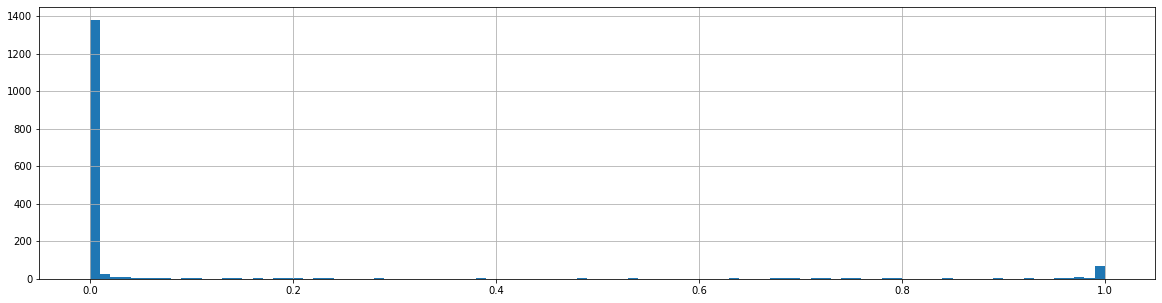

In [19]:
df_submit['smishing'].hist(bins=100, figsize=(20, 5))

In [20]:
(df_submit['smishing'] * 10).astype(int).value_counts(sort=False)

0    1445
1      19
2      12
3       7
4       5
5       8
6      14
7      18
8       6
9      92
Name: smishing, dtype: int64

In [21]:
print(model_ts)
df_submit[['smishing']].to_csv('submit/{}.csv'.format(model_ts), index=True)

20200102T011104


In [22]:
print(len(pred_cols))
df_test['pred_max'] = df_test[pred_cols].max(axis=1)
df_test['pred_min'] = df_test[pred_cols].min(axis=1)
df_test['pred_mean'] = df_test[pred_cols].mean(axis=1)
df_test['pred_std'] = df_test[pred_cols].std(axis=1)

print(df_test['pred_std'].max(), df_test['pred_std'].min(), df_test['pred_std'].mean())

df_test['smishing'] = df_test['pred_mean']

3


KeyError: "None of [Index(['smishing_3', 'smishing_4', 'smishing_5'], dtype='object')] are in the [columns]"

In [ ]:
df_test['smishing'].hist(bins=100, figsize=(20, 5))

In [ ]:
(df_test['smishing'] * 10).astype(int).value_counts(sort=False)

In [ ]:
# for c in pred_cols:
#     print(c)
#     display((df_test[c] * 10).astype(int).value_counts(sort=False))

In [ ]:
model_ts

In [ ]:
df_test['smishing'] = df_test['smishing']
df_test[['smishing']].to_csv('submit/{}.csv'.format(model_ts), index=True)


In [ ]:
# df_test['smishing'] = df_test['pred_mean']
# df_test[['smishing']].to_csv('submit/{}_lgb.csv'.format(model_ts), index=True)
# # df_test[['id', 'smishing', 'text']].sort_values('smishing', ascending=False).to_csv('{}_text.csv'.format(model_ts), index=False)
